# COGS 150 Final Project
*by Adeline Liem (A16399900)*


In the realm of natural language processing, understanding the nuanced shifts in sentiment within text is a critical aspect of language models' proficiency. This research seeks to investigate the sensitivity of LLMs to subtle changes in sentiment, aiming to uncover the extent to which these models can capture and respond to the intricate emotional nuances embedded within a given text.

Research question: Are LLMs sensitive to **changes in sentiment within a given text**?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer
from matplotlib import pyplot as plt
import transformers
import torch


%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

tokenizer = AutoTokenizer.from_pretrained("gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [2]:
# Loading gpt2

gpt2 = transformers.AutoModelForCausalLM.from_pretrained("gpt2")  # Load the model
gpt2.eval()  # Put the model in "evaluation mode" (as opposed to training mode).

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [3]:
# Defining surprisal

def surprisal(p):
  return -np.log2(p)

In [4]:
# Create stimuli

  # Stimuli where positive words are Expected are 'Positive', while stimuli where negative words are Expected are 'Negative'
stimuli = [
    ('Their loving hands gave me', ' comfort', 'Expected', 'Positive'),
    ('Their loving hands gave me', ' unease', 'Anomalous','Positive'),
    ('The heartwarming story left readers with a feeling of', ' joy', 'Expected','Positive'),
    ('The heartwarming story left readers with a feeling of', ' sorrow', 'Anomalous','Positive'),
    ('The enthusiastic team found a source of', ' motivation', 'Expected','Positive'),
    ('The enthusiastic team found a source of', ' despair', 'Anomalous','Positive'),
    ('The kind gesture filled the room with', ' gratitude', 'Expected','Positive'),
    ('The kind gesture filled the room with', ' resentment', 'Anomalous','Positive'),
    ('The lively music infused the atmosphere with', ' energy', 'Expected','Positive'),
    ('The lively music infused the atmosphere with', ' lethargy', 'Anomalous','Positive'),
    ('The touching moment brought feelings of', ' happiness', 'Expected','Positive'),
    ('The touching moment brought feelings of', ' disappointment', 'Anomalous','Positive'),
    ('A horrible sound echoed through the room, creating an atmosphere of', ' anxiety', 'Expected','Negative'),
    ('A horrible sound echoed through the room, creating an atmosphere of', ' joy', 'Anomalous','Negative'),
    ('The demoralizing twist in the plot left the audience with a sense of', ' dread', 'Expected','Negative'),
    ('The demoralizing twist in the plot left the audience with a sense of', ' excitement', 'Anomalous','Negative'),
    ("The hopeless team was a source of", ' frustration', 'Expected','Negative'),
    ("The hopeless team was a source of", ' inspiration', 'Anomalous','Negative'),
    ('The bad news filled the room with', ' despair', 'Expected','Negative'),
    ('The bad news filled the room with', ' relief', 'Anomalous','Negative'),
    ('The boring discussion infused the meeting with', ' monotony', 'Expected','Negative'),
    ('The boring discussion infused the meeting with', ' enthusiasm', 'Anomalous','Negative'),
    ('The hurtful comment brought feelings of', ' sadness', 'Expected','Negative'),
    ('The hurtful comment brought feelings of', ' joy', 'Anomalous','Negative'),
]

# Create dataframe
df_stimuli = pd.DataFrame(stimuli, columns = ['Sentence', 'Word', 'Condition', 'Stimuli Type'])

In [5]:
def next_seq_prob(model, tokenizer, seen, unseen):
    # Get ids for tokens
    input_ids = tokenizer.encode(seen, return_tensors="pt")
    unseen_ids = tokenizer.encode(unseen)

    # Loop through unseen tokens & store log probs
    log_probs = []
    for unseen_id in unseen_ids:

        # Run model on input
        with torch.no_grad():
            logits = model(input_ids).logits

        # Get next token prediction logits
        next_token_logits = logits[0, -1]
        next_token_probs = torch.softmax(next_token_logits, 0) # Normalize

        # Get probability for relevant token in unseen string & store
        prob = next_token_probs[unseen_id]
        log_probs.append(torch.log(prob))

        # Add input tokens incrementally to input
        input_ids = torch.cat((input_ids, torch.tensor([[unseen_id]])), 1)

    # Add log probs together to get total log probability of sequence
    total_log_prob = sum(log_probs)
    # Exponentiate to return to probabilities
    total_prob = torch.exp(total_log_prob)
    return total_prob.item()

In [6]:
# Calculate surprisal for stimuli

results = []
for index, row in tqdm(df_stimuli.iterrows(), total=df_stimuli.shape[0]):

  prob = next_seq_prob(gpt2, tokenizer, row['Sentence'], row['Word'])

  results.append({
      'Word': row['Word'],
      'Sentence': row['Sentence'],
      'Condition': row['Condition'],
      'Probability': prob,
      'Surprisal': surprisal(prob),
      'Stimuli Type': row['Stimuli Type']
  })

# Create dataframe with results
df_results = pd.DataFrame(results)
df_results

100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


,Word,Sentence,Condition,Probability,Surprisal,Stimuli Type
0,comfort,Their loving hands gave me,Expected,5.611990e-03,7.477272,Positive
1,unease,Their loving hands gave me,Anomalous,3.049045e-07,21.645139,Positive
2,joy,The heartwarming story left readers with a fee...,Expected,1.679683e-02,5.895667,Positive
3,sorrow,The heartwarming story left readers with a fee...,Anomalous,9.003974e-04,10.117150,Positive
4,motivation,The enthusiastic team found a source of,Expected,1.578111e-03,9.307586,Positive
5,despair,The enthusiastic team found a source of,Anomalous,5.413447e-05,14.173093,Positive
6,gratitude,The kind gesture filled the room with,Expected,3.513061e-03,8.153056,Positive
7,resentment,The kind gesture filled the room with,Anomalous,5.597793e-04,10.802854,Positive
8,energy,The lively music infused the atmosphere with,Expected,9.307514e-03,6.747388,Positive
9,lethargy,The lively music infused the atmosphere with,Anomalous,4.023659e-06,17.923060,Positive


# Visualizations

In [7]:
# Color palette
color_palette = {'Positive': '#5671EF', 'Negative': '#E64D4D'}

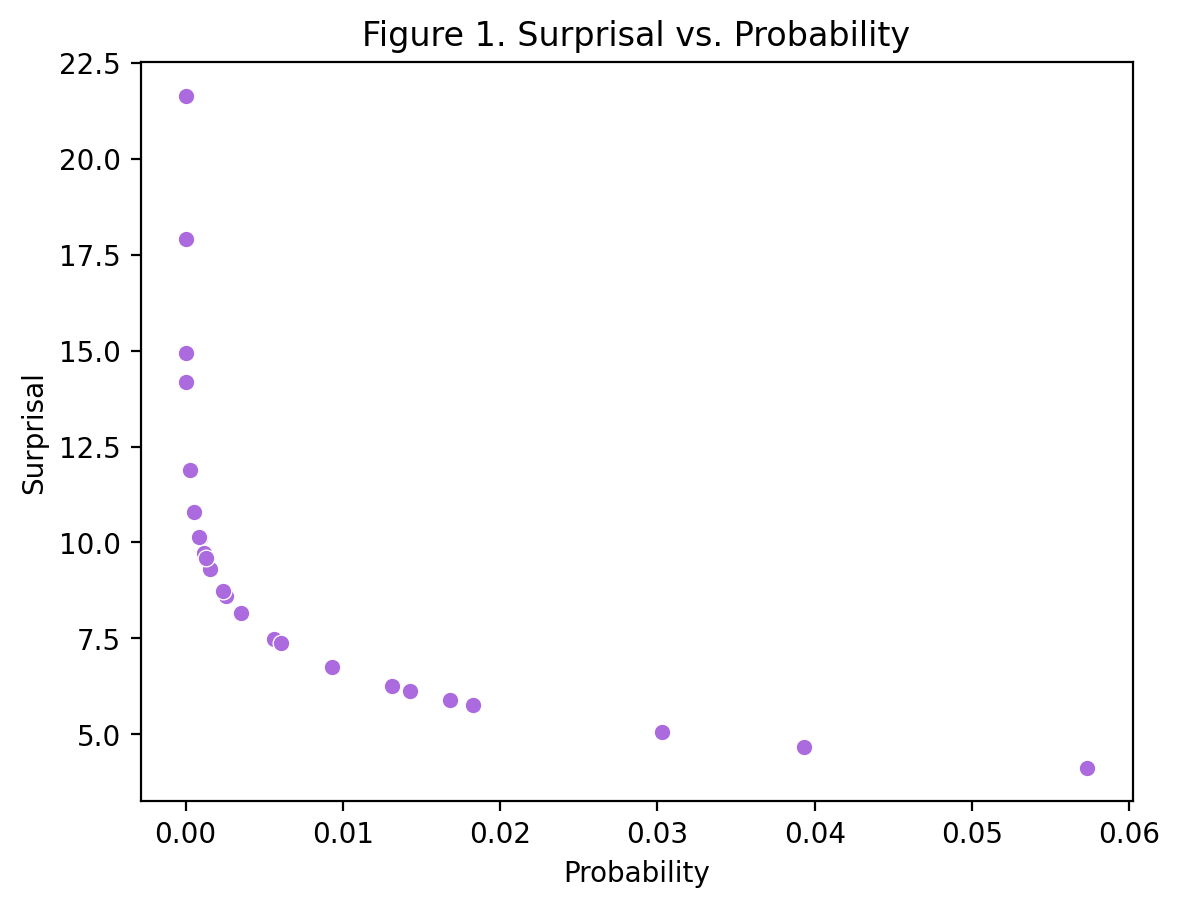

In [13]:
# Create scatterplot for surprisal vs. probability overall
sns.scatterplot(data=df_results, x='Probability', y='Surprisal', color = '#AC6ADF')

# Adding labels and title
plt.xlabel('Probability')
plt.ylabel('Surprisal')
plt.title('Figure 1. Surprisal vs. Probability')

# Displaying the plot
plt.show()


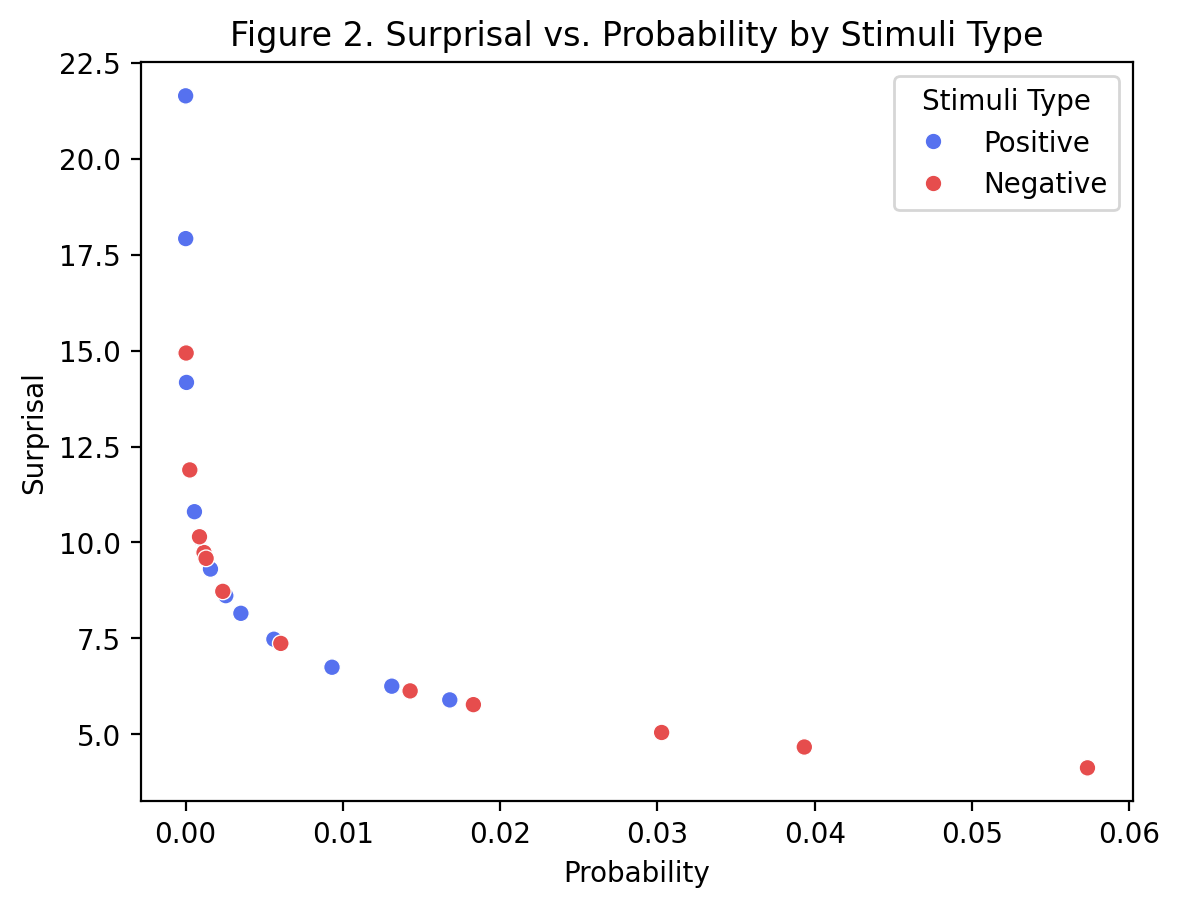

In [14]:
# Create scatterplot for surprisal vs. probability by stimuli type
sns.scatterplot(data=df_results, x='Probability', y='Surprisal', hue='Stimuli Type', palette = color_palette)

# Adding labels and title
plt.xlabel('Probability')
plt.ylabel('Surprisal')
plt.title('Figure 2. Surprisal vs. Probability by Stimuli Type')

# Displaying the plot
plt.show()


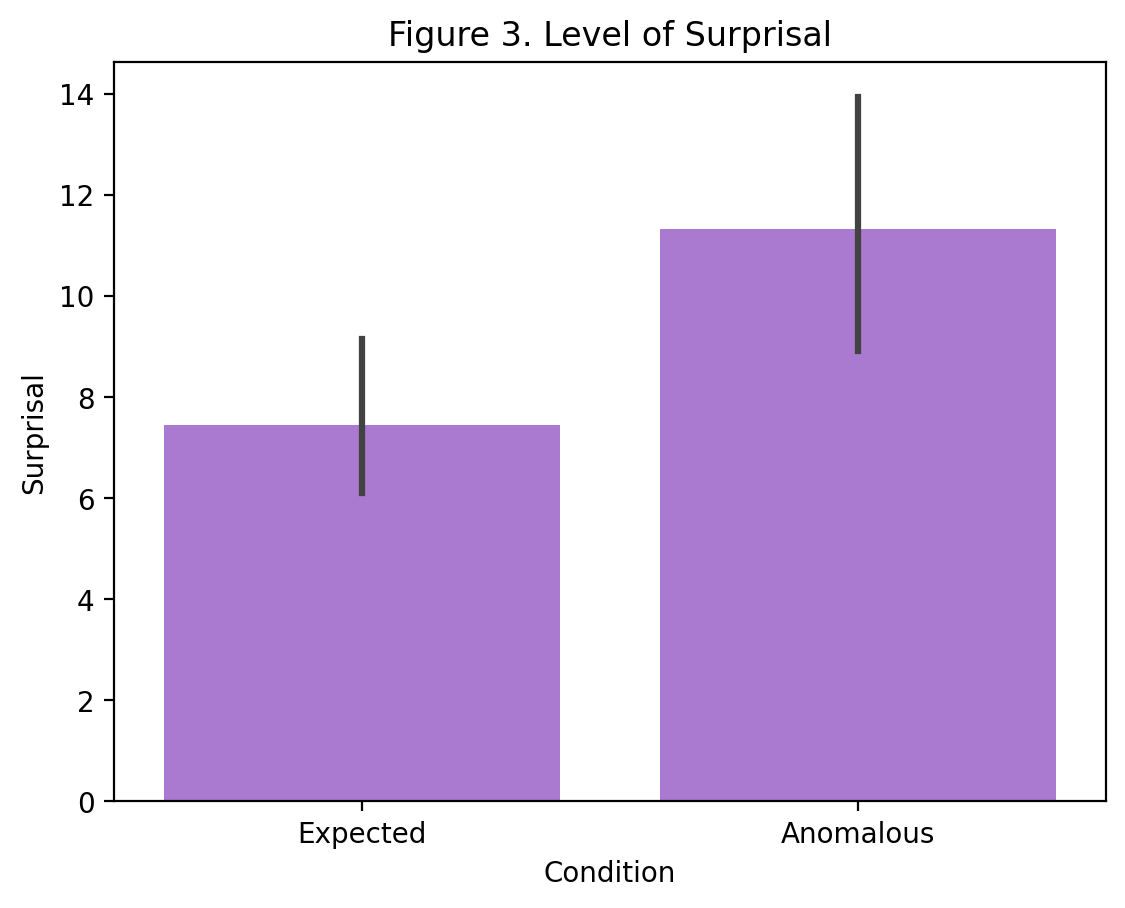

In [15]:
# Plotting level of surprisal by condition overall
sns.barplot(data=df_results, x="Condition", y="Surprisal",color = '#AC6ADF')

# Adding labels and title
plt.xlabel('Condition')
plt.ylabel('Surprisal')
plt.title('Figure 3. Level of Surprisal')

# Displaying the plot
plt.show()

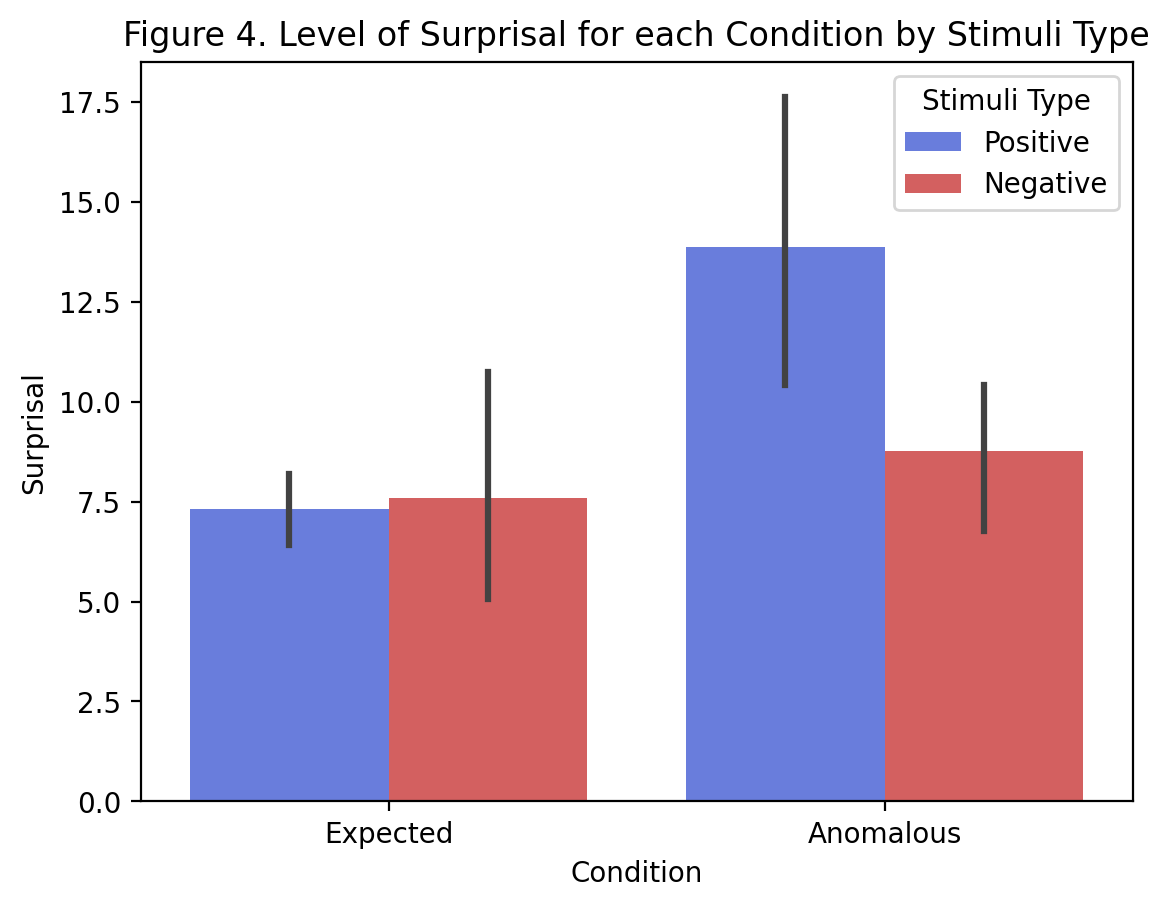

In [16]:
# Plotting level of surprisal by condition, specifying stimuli type
sns.barplot(data=df_results, x="Condition", y="Surprisal", hue="Stimuli Type",palette=color_palette)

# Adding labels and title
plt.xlabel('Condition')
plt.ylabel('Surprisal')
plt.title('Figure 4. Level of Surprisal for each Condition by Stimuli Type')

# Displaying the plot
plt.show()

# Results

My research aimed to explore whether or not LLMs display sensitivity to sentiment changes within a given text. In *Figure 1*, we can see that overall, surprisal and probability are inversely related, meaning that higher surprisal levels are associated with lower probabilities. This remains true when examining the same results for specifically Positive and Negative stimuli, as seen in *Figure 2*. Further, when plotting the level of surprisal based on condition, surprisal was found to be much higher overall for anomalous conditions, as seen in *Figure 3*. Interestingly, when examining the same results by Positive or Negative stimuli type, the results are more nuanced. The difference between surprisal levels between expected and anomalous conditions is much higher for Positive stimuli types compared to Negative stimuli types.



Based on my research, I propose that **LLMs do display some sensitivity to sentiment changes within a given text**. This is because the LLMs produced a higher surprisal rating for anomalous stimuli and stimuli with lower probabilities. However, it is important to note that the LLM used in this research, gpt2, displayed significantly **decreased sensitivity to sentiment changes when the Negative stimuli was categorized as expected**.

# Potential Confounds

The stimuli in my research was designed to minimize the possibility of factors such as sentence structure or length interfering with the results of the experiment. The sentence pairs all follow similar formats, and both negative and positive sentiment words are in the expected/anomalous conditions.

However, there are still potential confounds with the stimuli. As previously mentioned, all of the sentences follow a similar format, with the positive/negative word in the sentence as an adjective and the positive/negative word of interest as a noun. While this helps reduce the interference of word type on the results, it also means that there could be inherent biases or associations tied to the specific word pairings chosen.

Another possible confound is that all of the stimuli is in English. This restricts the generalizability of my findings to just English stimuli.

Finally, one of the most significant confounds is that what is considered "anomalous" is somewhat subjective. The stimuli chosen for this research was not selected based off of an empirical criteria for what is considered "anomalous".

# Implications

Being able to recognize sentiments as an AI have both positive and negative implications for the evolving capacity of LLMs. First, sentiment-aware LLMs can help create chatbots that provide more empathetic responses. These chatbots can better simulate a human-to-human experience, which can help users feel more comfortable. Also, they could enhance personalized recommendations and content curation, leading to improved user satisfaction and engagement.

However, there may be concerns about the over-reliance on LLMs for tasks that require sentiment awareness. There are risks of algorithmic biases within LLMS such as gpt2, which may perpetuate societal biases reflected in the training data.

Additionally, sentiment awareness in AI may also have implications for our under understanding of human cognition. For example, insights from sentiment-aware LLMs can inform our understandings of how sentiment and sentiment changes are expressed in linguistic communication.

Moreover, the integration of sentiment-aware LLMs in society can potentially impact human cognition if individuals begin to rely on these systems. Dependence on AI-driven sentiment analysis could potentially hinder human capacity for emotional understanding and interpersonal communication. Additionally, the widespread adoption of sentiment-aware LLMs could shape societal norms and behaviors surrounding emotional expression. If AI systems heavily influence the perception of what constitutes appropriate emotional responses, there is a risk of limiting the diversity of emotional experiences.

